# RNN with TensorFlow API

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/johnleonard/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### The Data

In [2]:
class TimeSeriesData():
    def __init__(self,num_pts, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_pts = num_pts
        self.resolution = (xmax-xmin)/num_pts
        self.x_data = np.linspace(xmin,xmax,num_pts)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts = False):
        #Grab a random starting pt for each batch
        rand_start = np.random.rand(batch_size,1)
        
        #Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        #Create batch time series on x-axis
        batch_ts = ts_start + np.arange(0.0, steps + 1)*self.resolution
        
        #Create y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        #Format for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [51]:
ts_data = TimeSeriesData(250,0,20)

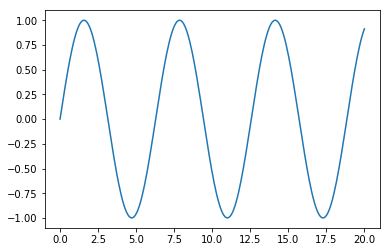

In [52]:
plt.plot(ts_data.x_data, ts_data.y_true)
plt.show()

In [61]:
n_time_steps = 100
y1,y2,ts = ts_data.next_batch(1,n_time_steps,True)

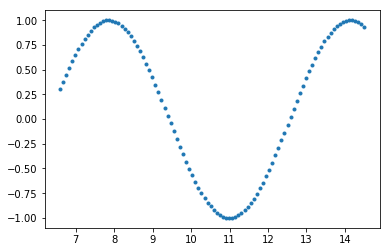

In [62]:
plt.plot(ts.flatten()[1:],y2.flatten(),".")
plt.show()

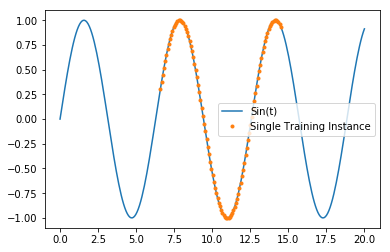

In [63]:
plt.plot(ts_data.x_data,ts_data.y_true,label = 'Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),".",label ='Single Training Instance')
plt.legend()
plt.show()

In [64]:
train_inst = np.linspace(5, 5+ts_data.resolution*(n_time_steps+1), n_time_steps+1)

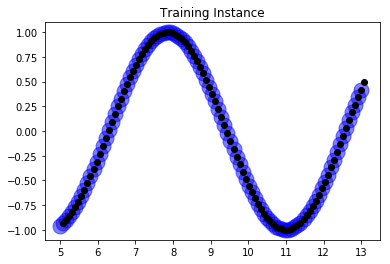

In [65]:
plt.title('Training Instance')
plt.plot( train_inst[:-1], ts_data.ret_true(train_inst[:-1]),
         'bo',alpha=0.5,label='Instance',markersize=15)

plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',alpha=1)

### Create the Model

In [66]:
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 0.001
n_train_iterations = 2000
batch_size = 1

In [67]:
tf.reset_default_graph()

# Placeholders
x = tf.placeholder(tf.float32, [None, n_time_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_time_steps, n_outputs])

# RNN Cell Layer
#cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation = tf.nn.relu)
cell = tf.contrib.rnn.GRUCell(num_units=n_neurons,activation = tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell,output_size=n_outputs)

# Outputs
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype = tf.float32)

# Loss
loss = tf.reduce_mean(tf.square(outputs-y)) #MSE

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

# Train
train = optimizer.minimize(loss)

#Save Fxn
saver = tf.train.Saver()

In [68]:
# Run the Session
# Prevent memory error on GPU:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.85)
# with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(n_train_iterations):
        x_batch, y_batch = ts_data.next_batch(batch_size, n_time_steps)
        
        sess.run(train,feed_dict={x:x_batch, y:y_batch})
        
        if i%100 == 0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(i,'\t MSE',mse)
    
    saver.save(sess,"./rnn_time_series_model_test2")

0 	 MSE 0.6612309
100 	 MSE 0.018151136
200 	 MSE 0.003032502
300 	 MSE 0.0020992076
400 	 MSE 0.0011958944
500 	 MSE 0.0032567135
600 	 MSE 0.0022415048
700 	 MSE 0.0030951328
800 	 MSE 0.0052191257
900 	 MSE 0.003211424
1000 	 MSE 0.0027440528
1100 	 MSE 0.001770604
1200 	 MSE 0.00014137638
1300 	 MSE 0.00013966428
1400 	 MSE 0.0004570978
1500 	 MSE 0.0013300213
1600 	 MSE 0.000765303
1700 	 MSE 0.00047639103
1800 	 MSE 0.00075363414
1900 	 MSE 0.00036200046


In [69]:
with tf.Session() as sess:
    
    saver.restore(sess,'./rnn_time_series_model_test2')
    
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1,n_time_steps,n_inputs)))
    y_pred = sess.run(outputs, feed_dict={x:x_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_test2


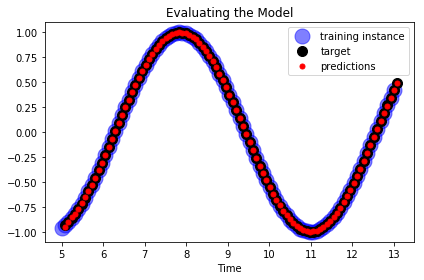

In [70]:
plt.title('Evaluating the Model')
#Training Instance
x_plot = train_inst[:-1]
plt.plot(x_plot ,np.sin(x_plot),'bo',markersize = 15, alpha =0.5, label = 'training instance')

#Target to Predict
x_plot  = train_inst[1:]
plt.plot(x_plot  ,np.sin(x_plot ),'ko',markersize = 10, alpha =1, label = 'target')

#Models Prediction
x_plot  = train_inst[1:]
y=y_pred[0,:,0]
plt.plot(x_plot ,y,'ro',markersize = 5, alpha =1, label = 'predictions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

# Generate a New Sequence

In [81]:

with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_test2")
    
    #Seed Zeros
    train_inst = list(ts_data.y_true[:100]) #seed with training instance data
    
    for i in range(len(ts_data.x_data) - n_time_steps):
        x_batch = np.array(train_inst[-n_time_steps:]).reshape(1,n_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={x:x_batch})
        
        train_inst.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_test2


Text(0,0.5,'Y')

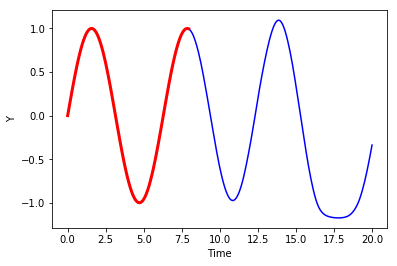

In [82]:
plt.plot(ts_data.x_data, train_inst, 'b-')
plt.plot(ts_data.x_data[:n_time_steps],train_inst[:n_time_steps],'r',linewidth = 3)
plt.xlabel('Time')
plt.ylabel('Y')